# import

In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [47]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [48]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [66]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [67]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [68]:
data['Cuisine Style'] = data['Cuisine Style'].fillna(value = 'Non') 

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [69]:
# Заполним пропуски числа отзывов средним значением
lst2 = []
for i in data['Number of Reviews'].value_counts().index:
    lst2.append(i)

average = sum(lst2)/len(lst2)

data['Number of Reviews'].fillna(average, inplace=True)


In [70]:
data.nunique(dropna=False)

Restaurant_id        13094
City                    31
Cuisine Style        10732
Ranking              12975
Price Range              4
Number of Reviews     1574
Reviews              41858
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [71]:
# Посчитаем, сколько всего есть видов кухонь
#Сначала найдем с помощью re все названия кухонь и перепишем их в списки
import re
pattern = re.compile('\w+\s*\&*\w*\s*\w*')
cuisines = []
for string in data['Cuisine Style']:
    if string != 'Non':
        c = pattern.findall(string)
    cuisines.append(c) 
#Теперь создадмит set, чтобы каждая кухня встречалась по 1 разу
cus = set()
for item in cuisines:
    for i in item:
        cus.add(i)
cus.add(i)
#Общее число кухонь
#len(cus) 

def find_item(cell):
    if item in cell:
        return 1
    return 0
        
for item in cus:
    data[item] = data['Cuisine Style'].apply(find_item)


In [72]:
data['City_dummies'] = data['City']
data = pd.get_dummies(data, columns=[ 'City_dummies',], dummy_na=True)

In [75]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,City_dummies_Oporto,City_dummies_Oslo,City_dummies_Paris,City_dummies_Prague,City_dummies_Rome,City_dummies_Stockholm,City_dummies_Vienna,City_dummies_Warsaw,City_dummies_Zurich,City_dummies_nan
32291,id_2664,Vienna,Non,2666.0,NaN,1023.228862,"[[], []]",/Restaurant_Review-g190454-d12439175-Reviews-H...,d12439175,1,...,0,0,0,0,0,0,1,0,0,0
11687,id_951,Athens,Non,953.0,NaN,7.000000,"[['Lovely Cafe', 'Wonderful cafe for coffee an...",/Restaurant_Review-g189400-d10035223-Reviews-M...,d10035223,1,...,0,0,0,0,0,0,0,0,0,0
12115,id_6185,Berlin,['African'],6187.0,NaN,2.000000,"[['Horrible Atmosphere in this Restaurant', 'A...",/Restaurant_Review-g187323-d1359963-Reviews-Af...,d1359963,1,...,0,0,0,0,0,0,0,0,0,0
14508,id_5895,Rome,['Chinese'],5897.0,$$ - $$$,13.000000,"[['Gem in Rome!!', 'Good food, good price.'], ...",/Restaurant_Review-g187791-d4066130-Reviews-Ji...,d4066130,1,...,0,0,0,0,1,0,0,0,0,0
21268,id_8684,Paris,"['French', 'Healthy']",8686.0,NaN,15.000000,"[['Healthy and tasteful'], ['09/11/2015']]",/Restaurant_Review-g187147-d6570873-Reviews-Po...,d6570873,1,...,0,0,1,0,0,0,0,0,0,0


#### Возьмем следующий признак "Price Range".

In [57]:
data['Price Range'].value_counts()


$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [78]:
# Ваша обработка 'Price Range'
data['Price Range'] = np.where(data['Price Range']== '$$$$', 3.0, data['Price Range'])
data['Price Range'] = np.where(data['Price Range'] == '$$ - $$$', 2.0, data['Price Range'])
data['Price Range'] = np.where(data['Price Range'] == '$', 1.0, data['Price Range'])
data['Price Range'] = data['Price Range'].fillna(value = 2)
data

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,City_dummies_Oporto,City_dummies_Oslo,City_dummies_Paris,City_dummies_Prague,City_dummies_Rome,City_dummies_Stockholm,City_dummies_Vienna,City_dummies_Warsaw,City_dummies_Zurich,City_dummies_nan
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,2.0,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,...,0,0,0,0,0,0,0,0,0,0
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,2.0,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,...,0,0,1,0,0,0,0,0,0,0
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,2.0,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,...,0,0,0,0,0,1,0,0,0,0
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,2.0,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,...,0,0,0,0,0,0,0,1,0,0


> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [79]:
# тут ваш код на обработку других признаков
#Введем параметр, отвечающий за число различных кухонь в ресторане
import re
pattern = re.compile('\w+\s*\&*\w*\s*\w*')
cuisines2 = []
length = []
for string in data['Cuisine Style']:  
    c = pattern.findall(str(string))
    cuisines2.append(c)
for item in cuisines2:
    length.append(len(item))
data['Num_of_cuis'] = length
data

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,City_dummies_Oslo,City_dummies_Paris,City_dummies_Prague,City_dummies_Rome,City_dummies_Stockholm,City_dummies_Vienna,City_dummies_Warsaw,City_dummies_Zurich,City_dummies_nan,Num_of_cuis
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,1,0,0,0,0,0,0,0,2
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0,0,0,0,0,0,0,0,0,5
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,0,0,0,0,0,0,0,0,0,1
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,0,0,0,0,0,0,0,0,0,5
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,0,0,0,0,0,0,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,2.0,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,...,0,0,0,0,0,0,0,0,0,4
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,2.0,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,...,0,1,0,0,0,0,0,0,0,5
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,2.0,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,...,0,0,0,0,1,0,0,0,0,2
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,2.0,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,...,0,0,0,0,0,0,1,0,0,5


In [80]:
#Введем параметры числа ресторанов в городе
d = pd.DataFrame(data.City.value_counts())
#Запишем в датафрейм количество ресторанов в каждом городе
def num(city):
    for i in range(0,len(d)):
        if city == d.index[i]:
            return int(d.values[i])
data['Number of rests'] = data['City'].apply(num)
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,City_dummies_Paris,City_dummies_Prague,City_dummies_Rome,City_dummies_Stockholm,City_dummies_Vienna,City_dummies_Warsaw,City_dummies_Zurich,City_dummies_nan,Num_of_cuis,Number of rests
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,1,0,0,0,0,0,0,0,2,6108
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0,0,0,0,0,0,0,0,5,475
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,0,0,0,0,0,0,0,0,1,745
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,0,0,0,0,0,0,0,0,5,7193
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,0,0,0,0,0,0,0,0,6,380


In [81]:
#перепишем словарь для чила жителей с помощью дополнительных данных
population = {'London': 9126366,
 'Paris': 2140526,
 'Madrid': 3223334,
 'Barcelona': 1636762,
 'Berlin': 3748148,
 'Milan': 1404239,
 'Rome': 2844750,
 'Prague': 1324277,
 'Lisbon': 506654,
 'Vienna': 1911191,
 'Amsterdam': 859732,
 'Brussels': 1211035,
 'Hamburg': 1899160,
 'Munich': 1471508,
 'Lyon': 515695,
 'Stockholm': 961609,
 'Budapest':1768073,
 'Warsaw': 1793579,
 'Dublin': 553165,
 'Copenhagen': 615993,
 'Athens': 655780,
 'Edinburgh': 507170,
 'Zurich': 402762 ,
 'Oporto': 214349,
 'Geneva': 499480,
 'Krakow': 766739,
 'Oslo': 673469,
 'Helsinki': 643272,
 'Bratislava':424428,
 'Luxembourg': 602005,
 'Ljubljana':279631 }

In [82]:
p = pd.DataFrame.from_dict(population, orient='index').T.unstack().dropna().reset_index(level=1,drop=True)

In [83]:
def popul(city):
    for i in range(0,len(population)):
        if city == p.index[i]:
            return int(p.values[i])
data['Population'] = data['City'].apply(popul)
data

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,City_dummies_Prague,City_dummies_Rome,City_dummies_Stockholm,City_dummies_Vienna,City_dummies_Warsaw,City_dummies_Zurich,City_dummies_nan,Num_of_cuis,Number of rests,Population
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,0,0,0,0,0,0,2,6108,2140526
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0,0,0,0,0,0,0,5,475,643272
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,0,0,0,0,0,0,0,1,745,507170
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,0,0,0,0,0,0,0,5,7193,9126366
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,0,0,0,0,0,0,0,6,380,424428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,2.0,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,...,0,0,0,0,0,0,0,4,2694,1404239
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,2.0,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,...,0,0,0,0,0,0,0,5,6108,2140526
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,2.0,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,...,0,0,1,0,0,0,0,2,1033,961609
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,2.0,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,...,0,0,0,0,1,0,0,5,925,1793579


In [87]:
data

,Restaurant_id,Ranking,Price Range,Number of Reviews,sample,Rating,Seafood,Fujian,Swiss,Latin,...,City_dummies_Prague,City_dummies_Rome,City_dummies_Stockholm,City_dummies_Vienna,City_dummies_Warsaw,City_dummies_Zurich,City_dummies_nan,Num_of_cuis,Number of rests,Population
0,id_0,12963.0,2.0,4.0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,2,6108,2140526
1,id_1,106.0,2.0,97.0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,5,475,643272
2,id_2,810.0,2.0,28.0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,1,745,507170
3,id_3,1669.0,3.0,202.0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,5,7193,9126366
4,id_4,37.0,3.0,162.0,0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,6,380,424428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,500.0,2.0,79.0,1,4.5,0,0,0,0,...,0,0,0,0,0,0,0,4,2694,1404239
49996,id_6340,6341.0,2.0,542.0,1,3.5,0,0,0,0,...,0,0,0,0,0,0,0,5,6108,2140526
49997,id_1649,1652.0,2.0,4.0,1,4.5,0,0,0,0,...,0,0,1,0,0,0,0,2,1033,961609
49998,id_640,641.0,2.0,70.0,1,4.0,0,0,0,0,...,0,0,0,0,1,0,0,5,925,1793579


In [86]:
data = data.drop(['Reviews','URL_TA','ID_TA','City','Cuisine Style'], axis =1)


KeyError: "['Reviews' 'URL_TA' 'ID_TA' 'City' 'Cuisine Style'] not found in axis"

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

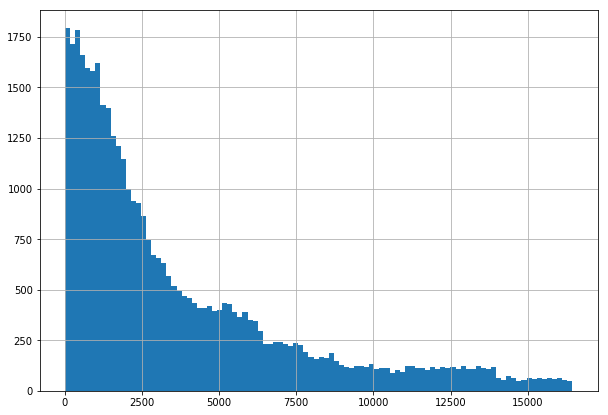

In [88]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

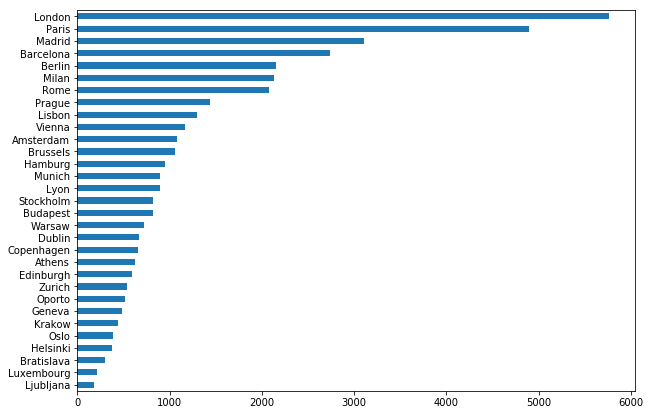

In [89]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

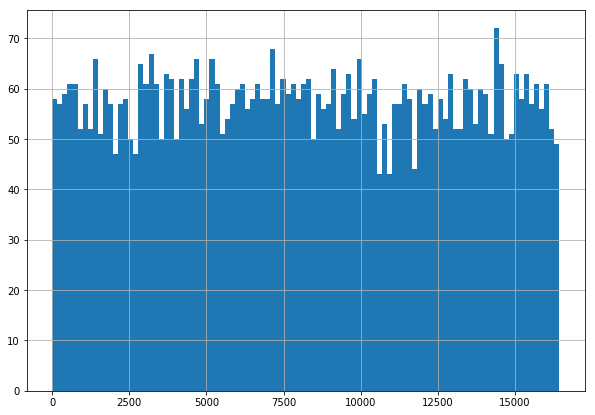

In [90]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

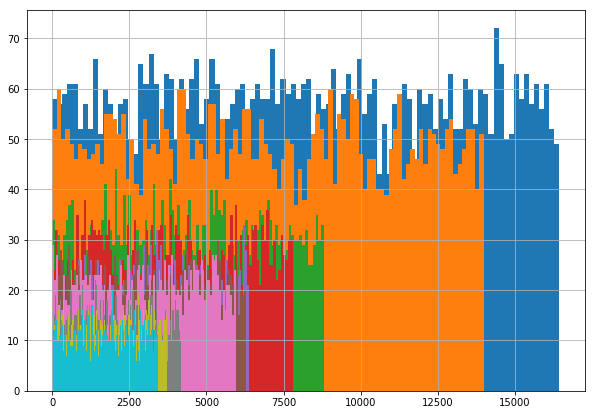

In [91]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

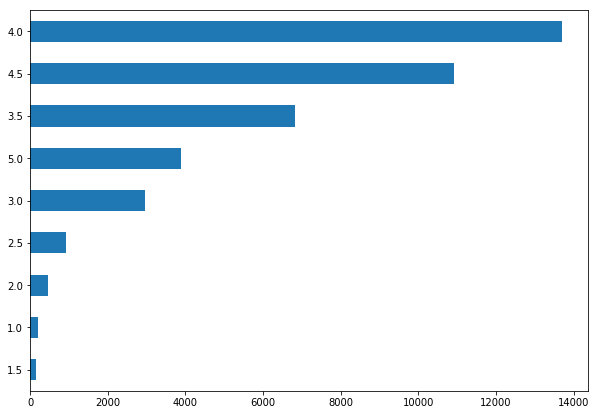

In [92]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

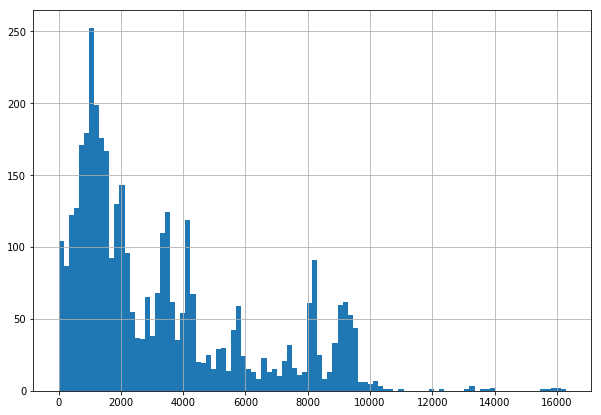

In [93]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

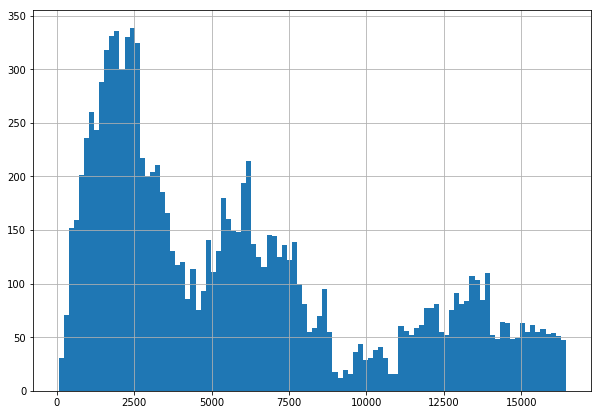

In [94]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

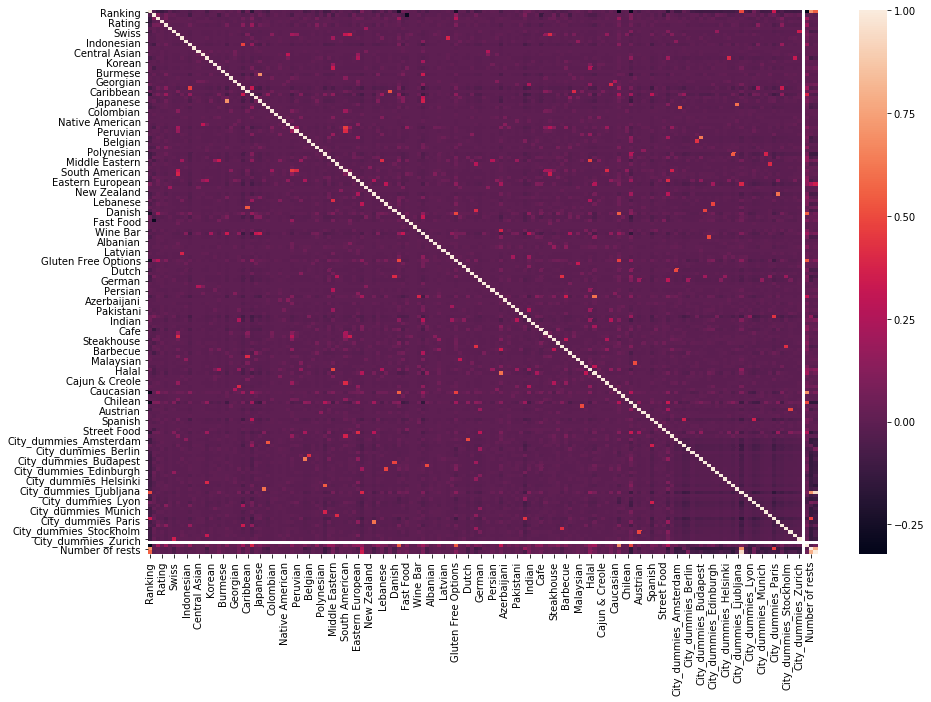

In [95]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [96]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [97]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [98]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Number of Reviews,sample,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
7588,611.0,30.0,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4578,702.0,6.0,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17499,2844.0,0.0,1,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35165,2596.0,5.0,1,3.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
40481,2538.0,11.0,1,4.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
33264,13851.0,18.0,1,3.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30388,13186.0,5.0,1,4.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36636,12891.0,3.0,1,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49584,2198.0,7.0,1,3.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8134,1393.0,97.0,0,0.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [99]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 36 columns):
Ranking              50000 non-null float64
Number of Reviews    50000 non-null float64
sample               50000 non-null int64
Rating               50000 non-null float64
City_Amsterdam       50000 non-null uint8
City_Athens          50000 non-null uint8
City_Barcelona       50000 non-null uint8
City_Berlin          50000 non-null uint8
City_Bratislava      50000 non-null uint8
City_Brussels        50000 non-null uint8
City_Budapest        50000 non-null uint8
City_Copenhagen      50000 non-null uint8
City_Dublin          50000 non-null uint8
City_Edinburgh       50000 non-null uint8
City_Geneva          50000 non-null uint8
City_Hamburg         50000 non-null uint8
City_Helsinki        50000 non-null uint8
City_Krakow          50000 non-null uint8
City_Lisbon          50000 non-null uint8
City_Ljubljana       50000 non-null uint8
City_London          50000 non-null uint8
Cit

In [100]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [101]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [102]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 35), (40000, 35), (40000, 34), (32000, 34), (8000, 34))

# Model 
Сам ML

In [103]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [104]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [105]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [106]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21240125


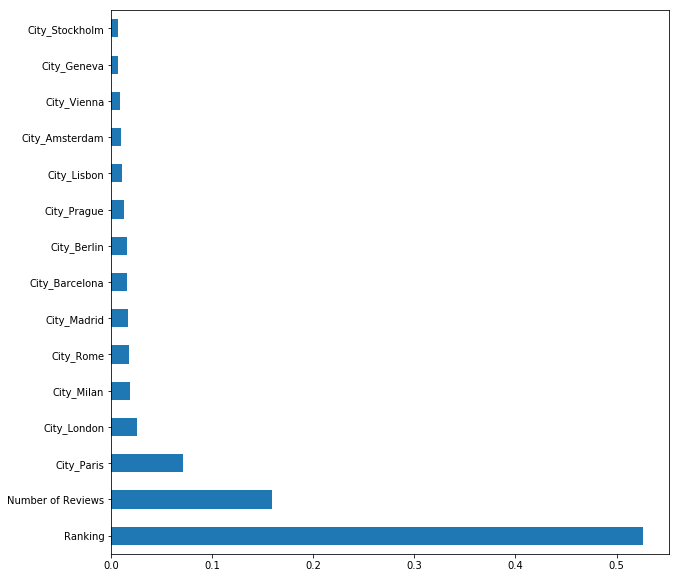

In [107]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [108]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
8224,3005.0,40.0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8957,611.0,81.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6519,773.0,48.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8668,16163.0,2.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8065,11613.0,6.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7285,1951.0,35.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3548,168.0,335.0,0.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2086,1977.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6174,816.0,10.0,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3704,1345.0,146.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [109]:
test_data = test_data.drop(['Rating'], axis=1)

In [110]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [111]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [112]:
predict_submission

array([3.005, 4.295, 4.56 , ..., 3.   , 4.5  , 4.32 ])

In [113]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.005
1,id_1,4.295
2,id_2,4.560
3,id_3,4.155
4,id_4,4.485
5,id_5,4.580
6,id_6,1.475
7,id_7,3.220
8,id_8,4.100
9,id_9,4.750


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
